In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import minepy
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_selection import RFECV, GenericUnivariateSelect
from sklearn.ensemble import RandomForestClassifier

In [2]:
import os
os.chdir(r'C:\test\data\santander-customer-transaction-prediction')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### 特征相关系数
- 装饰器函数，使得被装饰函数可以处理DataFrame数据，使得接口一致
- 计算特征与特征之间或特征与label之间的相关系数。用于进行特征选择
- 可视化相关系数，对于特征与特征之间的相关系数为heatmap,特征与label之间为火柴图。
- 相关系数除了常见的pearson,spearman, kendall之外，添加的MIC，距离相关系数。

In [24]:
'''Compute the first Wasserstein distance between two 1D distributions.'''
stats.wasserstein_distance()#数值特征，分类，返回值为距离
'''Compute the energy distance between two 1D distributions.'''
stats.energy_distance()# 数值特征分类，返回值为距离
def decorate(f): #装饰器，使得可以使用DataFrame。
    def inner(self,features, target=None):
        if isinstance(features,np.ndarray):
            result = f(self,features,target)
        else:
            self.columns = features.columns
            if target is None:
                result = f(self,features.values,target)
            else:
                result = f(self,features.values,target.values)
        return result
    return inner

class FeatureRelation:
    def __init__(self):
        self.columns = None
        
    @decorate
    def pearson(self, X, y=None): # 皮尔逊相关系数
        m,n = X.shape
        if y is None:
             # 计算特征与label之间的相关系数
            result = []
            for i in range(n-1):
                for j in range(i+1,n):
                    value,_ = stats.pearsonr(X[:,i],X[:,j])
                    result.append(value)
            return squareform(result)+np.identity(n)
        # 计算特征与特征之间的相关系数
        result = [stats.spearmanr(X[:,j], y)[0] for j in range(n)]
        return np.array(result) 
    
    @decorate
    def spearman(self, X, y=None): #斯皮尔曼相关系数
        if y is None:
            result,_ = stats.spearmanr(X)
            return result
        m,n = X.shape
        result=[stats.spearmanr(X[:,j],y)[0] for j in range(n)]
        return np.array(result)
    
    @decorate
    def kendall(self,X, y=None): # Kendall相关系数
        m,n = X.shape
        if y is None:
            result = []
            for i in range(n-1):
                for j in range(i+1,n):
                    value,_ = stats.kendalltau(X[:,i],X[:,j])
                    result.append(value)
            return squareform(result)+np.identity(n)
        result = [stats.kendalltau(X[:,j], y)[0] for j in range(n)]
        return np.array(result) 
    
    @decorate
    def mic(self, X, y=None): # 最大信息系数
        X=X.transpose(1,0)
        if y is None:
            mic = minepy.pstats(X)+np.identity(X.shape[1])
            return mic
        y = y[None,:]
        result,_ = minepy.cstats(X,y)
        return result.ravel()
    
    def _distcorr(self, X, Y):
        X = X[:, None]
        Y = Y[:, None]
        n = X.shape[0]
        a = squareform(pdist(X))
        b = squareform(pdist(Y))
        A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
        B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

        dcov2_xy = (A * B).sum()/float(n * n)
        dcov2_xx = (A * A).sum()/float(n * n)
        dcov2_yy = (B * B).sum()/float(n * n)
        dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
        return dcor
    
    @decorate
    def distcorr(self, X,y=None):  #距离相关系数,适用于数值特征
        m,n = X.shape
        if y is None:
            result = []
            for i in range(n-1):
                for j in range(i+1,n):
                    value = self._distcorr(X[:,i],X[:,j])
                    result.append(value)
            return squareform(result)+np.identity(n)
        result = [self._distcorr(X[:,j], y) for j in range(n)]
        return np.array(result)
    
    def plot_corr(self,data,target=None):  #相关系数的可视化
        fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
        ax.set_ylabel('Correlogram')
        if target is None: # heatmap的可视化
            data = pd.DataFrame(data,columns=self.columns,
                                index=self.columns)
            sns.heatmap(data, xticklabels=data.columns, 
            yticklabels=data.columns, cmap='RdYlGn',
            center=0, annot=True,ax=ax)
        else: 
            # 特征与label之间的相关性的可视化。
            data = pd.Series(data, 
                             index=self.columns).abs().sort_values()
            data=data.reset_index()
            data.columns=['a','b']
            ax.vlines(x=data.index, ymin=0, ymax=data['b'], 
                      color='firebrick', alpha=0.7, linewidth=2)
            ax.scatter(x=data.index, y=data['b'], s=75, 
                       color='firebrick', alpha=0.7)
            ax.set_title('Correlogram', 
                         fontdict={'size':22})
            ax.set_xticks(data.index)
            mn,mx = ax.get_xbound()
            ax.hlines(y=0,xmin=mn,xmax=mx,linestyles='--')
            ax.set_xticklabels(data['a'].str.upper(), 
                    rotation=60, 
                fontdict={'horizontalalignment': 'right', 'size':12})
            for row in data.itertuples():
                ax.text(row.Index, row.b*1.01, s=round(row.b, 2),
                        horizontalalignment= 'center',
                        verticalalignment='bottom', fontsize=14)

In [4]:
y = train.pop('target')
_ = train.pop('ID_code')
_ = test.pop('ID_code')

In [25]:
X = train.iloc[:5000,:20]
X_test = test.iloc[:5000,:20]
fr = FeatureRelation()

In [7]:
Y = y[:5000]

In [9]:
fr.spearman(X,Y)

array([ 0.02733949,  0.06722469,  0.05094245,  0.03592691,  0.03040868,
        0.02251852,  0.02384293,  0.00729689,  0.00856335, -0.02736146,
       -0.00789624,  0.00793549, -0.04166199, -0.03997913, -0.00044046,
        0.00955316,  0.01614928, -0.00421625,  0.03416905,  0.01202603])

In [11]:
fr.mic(X,Y)

array([0.07450675, 0.07613787, 0.0751125 , 0.07293062, 0.06853842,
       0.07559424, 0.07641534, 0.07450881, 0.0685764 , 0.07527825,
       0.07399646, 0.07009313, 0.0710871 , 0.07729425, 0.07208119,
       0.07246488, 0.06951951, 0.07437322, 0.07852151, 0.07341076])

In [12]:
fr.distcorr(X,Y)

array([0.0364733 , 0.067022  , 0.05920578, 0.03522793, 0.03205672,
       0.0311817 , 0.03778666, 0.01227514, 0.01269634, 0.03753824,
       0.01101738, 0.01376633, 0.04562283, 0.04884396, 0.01066506,
       0.01582655, 0.0215273 , 0.01137594, 0.03700323, 0.03686994])

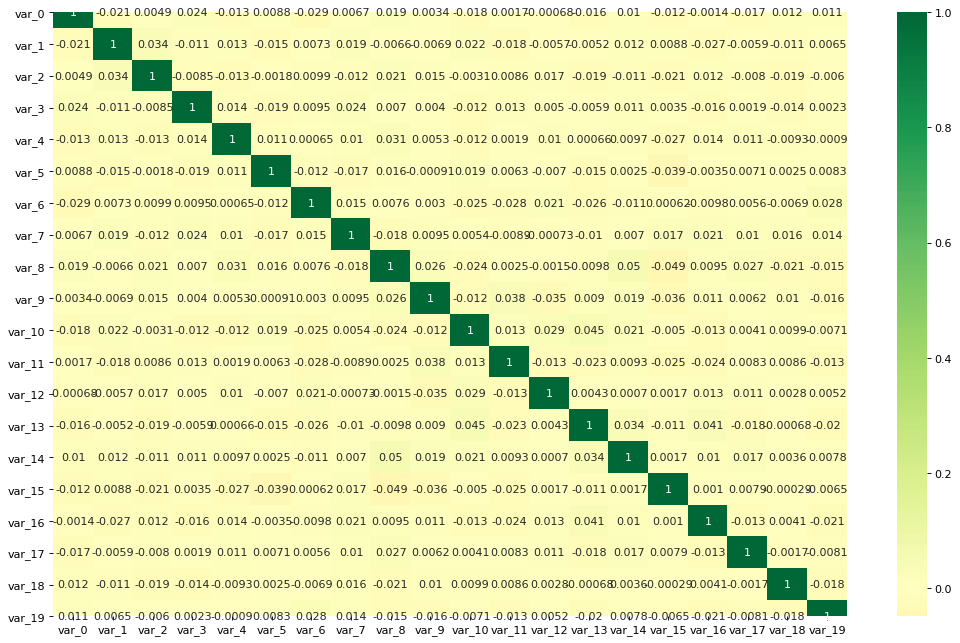

In [14]:
import seaborn as sns
fr.plot_corr(fr.spearman(X))

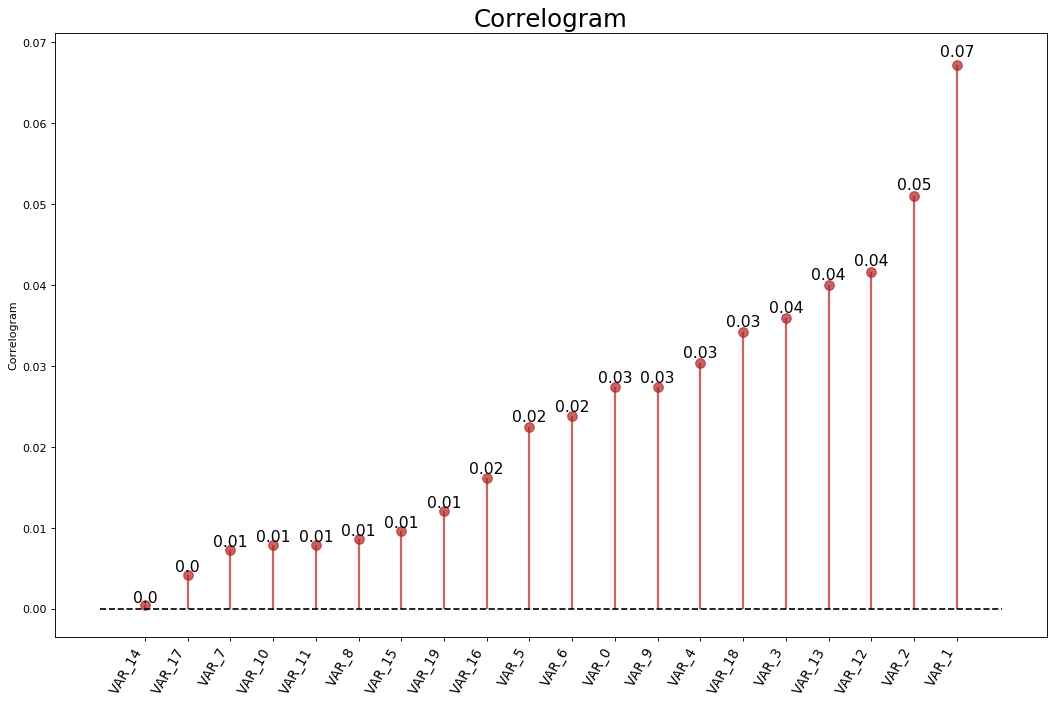

In [26]:
fr.plot_corr(fr.spearman(X,Y),Y)

### 特征选择
- filter特征选择，将特征选择过程与建模过程独立，作为数据处理的一个过程，选取相关系数最大的K个特征，默认原始特征的一半。
- wrapper特征选择，根据模型进行特征选择，使用了后向删除，不断删除权重小的特征，并最终得到需要结果。 the goal of recursive feature elimination is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_` attribute or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.
- Recursive feature elimination:首先在所有特征的情况下建模，得到每个特征的重要性，从中删除最不重要的特征，不断循环上述过程，直到满足条件。

In [27]:
class FeatureSelection:
    def __init__(self,estimator=None, to_select=None,score='roc_auc'):
        if estimator is None: #用于进行wrapper方法的模型
            self.estimator = RandomForestClassifier(n_estimators=10,
                                                max_depth=4)
        else:
            self.estimator = estimator
        self.score = score #评估标准
        self.masked = None #得到的mask掩码，用于测试集
        
    def select_by_filter(self, func, X, y):
        # filter方法进行可视化。
        to_select = X.shape[1]//2
        gus = GenericUnivariateSelect(func, 'k_best', 
                                              param=to_select)
        gus.fit(X,y)
        self.masked = gus.get_support()
    
    def select_by_wrapper(self, X, y):
        step = max(1,X.shape[1]//50)
        to_select = X.shape[1]//2
        clf = RFECV(self.estimator,step=step,
                min_features_to_select=to_select, scoring=self.score,
                   cv=5, n_jobs=-1)
        clf.fit(X,y)
        self.masked = clf.support_
        
    def __call__(self, X, y=None,func=None):
        if y is None:
            return X.loc[:,self.masked]
        else:
            '''如果提供了评估特征与label关系的函数则采用filter，否则wrapper'''
            if func is None:
                self.select_by_wrapper(X, y)
                return X.loc[:,self.masked]
            else:
                self.select_by_filter(func,X,y)
                return X.loc[:,self.masked]

In [29]:
fs = FeatureSelection(to_select=10)
s_X=fs(X,Y,func=fr.spearman)
s_X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_16,var_18,var_19
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,5.7487,4.2840,30.7133
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,13.8275,7.8000,28.5708
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,7.6782,4.7011,20.4775
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,10.7430,15.9426,13.7257
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,8.4871,6.5263,11.3152


In [30]:
s_X_test = fs(X_test)
s_X_test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_16,var_18,var_19
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,7.7028,15.5806,16.1763
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,7.0196,29.1609,0.0910
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,9.8837,21.2181,20.8163
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,10.0383,2.1273,21.4797
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,11.8615,18.0126,13.8006


In [31]:
s_x_1 = fs(X,Y)
s_x_1.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_8,var_9,var_12,var_13,var_14,var_15,var_17,var_18,var_19
0,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,-4.9200,5.7470,14.0137,0.5745,8.7989,14.5691,-7.2393,4.2840,30.7133
1,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,3.1468,8.0851,14.0239,8.4135,5.4345,13.7003,-15.5849,7.8000,28.5708
2,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,-4.9193,5.9525,14.1929,7.3124,7.5244,14.6472,-1.7395,4.7011,20.4775
3,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,-5.8609,8.2450,13.8463,11.9704,6.4569,14.8372,-0.4299,15.9426,13.7257
4,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,6.2654,7.6784,13.8481,7.8895,7.7894,15.0553,-3.0680,6.5263,11.3152


#### 其他特征选择方法
- 通过对单个特征与label进行建模，选择结果最好的K个作为结果，这个可以融入filter特征选择方法中。
- 通过对其中某个特征的值进行随机重组，查看结果中精度下降的程度来确定模型的重要性。
- 通过树模型的feature importance来对特征进行选择，树模型特定的特征选择方法，并对选择过程进行可视化。

In [ ]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
def each_feature_select(rf, features, y, scoring):
    names = features.columns
    X,Y = features.values, y.values
    scores=[]
    for i in range(X.shape[1]):
        score = cross_val_score(rf, X[:, i:i+1], Y, scoring=scoring,
                              cv=ShuffleSplit(5, .3))
        scores.append((round(np.mean(score), 3), names[i]))
    return sorted(scores, reverse=True)

from collections import defaultdict
def average_decrease(rf, features, y, scoring):
    names = features.columns
    X, Y = features.values,y.values
    scores = defaultdict(list)
    for train_idx, test_idx in ShuffleSplit(10, .3).split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        r = rf.fit(X_train, Y_train)
        acc = scoring(Y_test, rf.predict_proba(X_test)[:,1])
        for i in range(X.shape[1]):
            X_t = X_test.copy()
            np.random.shuffle(X_t[:, i])
            shuff_acc = scoring(Y_test, rf.predict_proba(X_t)[:,1])
            scores[names[i]].append((acc-shuff_acc)/acc)
    return sorted([(round(np.mean(score), 4), feat) for feat,
              score in scores.items()], reverse=True)

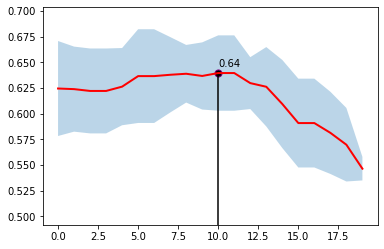

In [34]:
def selectwithfeatureimportance(estimator, X, Y):
    kf = StratifiedKFold(10)
    model = estimator()
    model.fit(X, Y)
    thresholds = np.sort(model.feature_importances_)
    result = np.zeros(shape=(len(thresholds),10))
    support = None
    baseline = -np.inf
    for i, thresh in enumerate(thresholds):
        score = 0
        selection = SelectFromModel(model, threshold=thresh, 
                                    prefit=True)
        for j,(tidx, vidx) in enumerate(kf.split(X, Y)): #cv计算均值和方差
            X_train, X_valid = X.iloc[tidx, :], X.iloc[vidx, :]
            y_train, y_valid = Y.iloc[tidx], Y.iloc[vidx]
            select_X_train = selection.transform(X_train)
            selection_model = estimator()
            selection_model.fit(select_X_train, y_train)
            select_X_test = selection.transform(X_valid)
            y_pred = selection_model.predict_proba(select_X_test)[:,1]
            score += roc_auc_score(y_valid,y_pred)/5
            result[i,j] = roc_auc_score(y_valid,y_pred)
        if score > baseline:
            support = selection.get_support()
            baseline = score
    return support,result,baseline

def plot_process(result):
    x,mean,std = range(result.shape[0]),result.mean(axis=1),result.std(axis=1)
    ax = plt.subplot(1,1,1)
    ax.plot(x,mean,color='red',lw=2)
    ax.fill_between(x, mean+std, mean-std, alpha=0.3)
    ax.scatter(mean.argmax(),mean.max(),color='black',s=50,
               edgecolors='purple')
    ax.vlines(mean.argmax(),0,mean.max())
    ax.text(mean.argmax(),mean.max()*1.01,'{:.2f}'.format(mean.max()))
    ax.set_ylim(mean.min()*0.9,mean.max()*1.1)
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
est = xgb.XGBClassifier
support,result,baseline = selectwithfeatureimportance(est,X,Y)
plot_process(result)

In [ ]:
def wassertein(df1,y): # wasserstein距离
    df = df1.copy()
    result = []
    for each in df:
        df[each] = (df[each]-df[each].mean())/df[each].std()
        b0 = df.loc[y==0, each]
        b1 = df.loc[y==1, each]
        w = stats.wasserstein_distance(b0,b1)
        result.append(w)
    return result

### 特征编码
- 字典用于保存训练数据集的信息，用于测试集和验证集进行编码
- `onehot-encode`：用于对特征进行OneHot-Encoding
- `count-encode`：对特征进行计数特征编码
- `labelcount-encode`：对特征进行计数排序编码
- `target-encode`:用于对特征进行目标编码
- `transform`:用于对验证集和测试集进行编码

In [ ]:
class Encoding:
    def __init__(self):
        self.count_encode_map = { }
        self.labelcount_encode_map={ }
        self.target_encode_map = { }
        self.onehot_encode_map = { }
        
    def onehot_encode(self,data,features):
        import re
        pattern = re.compile(r'x(\d+)')
        enc = OneHotEncoder(categories='auto',handle_unknown='ignore')
        enc.fit(data[features])
        self.onehot_encode_map[tuple(features)] = enc
        temp = enc.transform(data[features]).toarray()
        self.columns = [features[int(pattern.search(item
                        ).groups(1)[0])]+'_'+item.split('_') [-1]
                   for item in enc.get_feature_names()]
        df = pd.DataFrame(temp,index = data.index,columns=self.columns) 
        return df
    
    def count_encode(self,data,features,normalize=False):
        df = pd.DataFrame()
        for feature in features:
            temp = data[feature].value_counts() 
            if normalize:
                mapping = temp/temp.max()
            else:
                mapping = temp
            self.count_encode_map[feature] = mapping
            df[feature] = data[feature].astype('object').map(mapping)
        if normalize:
            df = df.astype(np.float32)
        else:
            df = df.astype(np.float32)
        df = df.add_suffix('_count_encode')
        return df
    
    def labelcount_encode(self,data,features,ascending=False):
        df = pd.DataFrame()
        for feature in features:
            mapping = data[feature].value_counts(
            ).rank(method='min', ascending=ascending)
            self.labelcount_encode_map[feature] = mapping
            df[feature] = data[feature].astype('object').map(mapping)
        df = df.astype(np.float32)
        df = df.add_suffix('_labelcount_encode')
        return df
    
    def target_encode(self, data, features, y):
        name = y.name
        df = pd.DataFrame()
        temp = pd.concat([data,y],axis=1)
        for feature in features:
            mapping = temp.groupby(feature)[name].mean()
            self.target_encode_map[feature] = mapping
            df[feature] = data[feature].astype('object').map(mapping)
        df = df.add_suffix('_target_encode')
        df = df.astype(np.float32)
        return df
    
    def transform(self,Xtest):
        df = pd.DataFrame()
        for key in self.count_encode_map:
            df[key+'_count_encode'] = Xtest[key].map(
                self.count_encode_map[key])
        for key in self.labelcount_encode_map:
            df[key+'_labelcount_encode'] = Xtest[key].map(
            self.labelcount_encode_map[key])
        for key in self.target_encode_map:
            df[key+'_target_encode'] = Xtest[key].map(
            self.target_encode_map[key])
        if self.onehot_encode_map != {}:
            features, enc = list(self.onehot_encode_map.items())[0]
            temp = enc.transform(Xtest[list(features)]).toarray()
            df = pd.DataFrame(temp,index=Xtest.index,columns=self.columns)
        df.astype(np.float32)
        return df

In [ ]:
class Encoding:
    
    def __init__(self,threshold=15):
        self.threshold = threshold
        self.cat = None
        self.n_index = None
        self.num = None
        self.encs = {}
        
    def onehot(self, data,trainable=True,method='cat'):
        if data.empty:
            return data
        names = data.columns
        features={'x{}'.format(i):names[i] for i in range(len(names))}
        if trainable:
            enc = OneHotEncoder(categories='auto',handle_unknown='ignore')
            self.encs[method] = enc
            enc.fit(data)
        else:
            enc = self.encs[method]
        pre_columns = enc.get_feature_names()
        columns = [features[each.split('_',1)[0]]+'_'+each.split('_',1)[1]
                   for each in pre_columns]
        res = enc.transform(data).toarray()
        result = pd.DataFrame(res,columns=columns)
        return result
    
    def __call__(self, data, trainable=True):
        if trainable:
            self.cat, self.num, self.n_index = self.split_cat_num(data)                
            cates = self.onehot(data.loc[:,self.cat],method='cat')
            n_indexs = self.onehot(data.loc[:,self.n_index],
                                   method='n_index')
            data = pd.concat((cates, n_indexs, 
                               data.loc[:,self.num]),axis=1)
        else:
            cates = self.onehot(data.loc[:,self.cat],trainable=trainable,
                                method='cat')
            n_indexs = self.onehot(data.loc[:,self.n_index],
                                   trainable=trainable,method='n_index')
            data = pd.concat((cates, n_indexs, 
                               data.loc[:,self.num]),axis=1)
        return data

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
from abc import abstractmethod
import re
from functools import partial

class TargetEncode:
    def __init__(self):
        self.map_ = {}
        self.mean_ = None
        self.none_ = {}
        
    def fit(self,X,y):
        self.mean_ = y.mean()
        name = y.name
        df = pd.concat([X,y],axis=1)
        for each in X:
            data = df.groupby(each)[name].mean()
            self.map_[each] = data.to_dict()
            self.none_[each] = y[pd.isnull(df[each])].mean()
        return self
    
    def transform(self,X):
        result = X.copy()
        for each in X:
            result[each] = X[each].map(
                lambda x,column=each: self.func(x,column) + self.mean_)
        return result
    
    def func(self,x,column=None):
        if pd.isnull(x):
            return self.none_.get(column,0)
        else:
            return self.map_[column].get(x,0)